In [11]:
import pandas as pd
from datetime import datetime, timedelta, date
import time
import re


from transformers import pipeline

In [5]:
df = pd.read_csv('stock_tweets.csv')


In [6]:
df['Stock Name'].value_counts()

Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

In [6]:
list_of_stocks = ['TSLA', 'TSM', 'AAPL', 'AMZN', 'MSFT']
list_of_twitter_username = ['@Tesla', '@TWSemicon', '@Apple', '@Microsoft'] 



In [10]:
df = df[df['Stock Name'].isin(list_of_stocks)]

df


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
73770,2021-09-30 01:24:38+00:00,Hotancold drops 21 kills and a 2.33 rating as ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...
73771,2021-09-30 00:24:50+00:00,@TSM_Myth dude SO fun. you killed it pitching ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...
73772,2021-09-30 00:16:45+00:00,@TSM_Myth You did amazing stop it!!!!!,TSM,Taiwan Semiconductor Manufacturing Company Lim...
73773,2021-09-30 00:14:49+00:00,@TSM_Myth You did great!!! Don’t be so hard on...,TSM,Taiwan Semiconductor Manufacturing Company Lim...


In [14]:
# Function to remove @mentions except for those in mentions_to_keep
def remove_mentions(tweet):
    # Function to check if a mention is in the list of mentions to keep
    def keep_mention(match):
        mention = match.group()
        return mention if mention in list_of_twitter_username else ''

    
    
    return re.sub(r'@\w+', keep_mention, tweet)

# Apply the function to remove @mentions

df['Tweet'] = df['Tweet'].apply(remove_mentions)
df.to_csv("formated_tweets.csv")








In [15]:
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")




In [23]:
df_tesla = df[df['Stock Name'] == "TSLA"]


In [24]:
%%time

scores = pipe(list(df_tesla['Tweet']))






CPU times: user 29min 14s, sys: 7min 24s, total: 36min 39s
Wall time: 30min 3s


In [47]:
## Concatenate dfs

df_tesla = pd.concat([df_tesla, pd.DataFrame(scores)], axis=1)

In [49]:
df_tesla


,Date,Tweet,Stock Name,Company Name,label,score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",neutral,0.769167
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",neutral,0.940500
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",neutral,0.930985
3,2022-09-29 22:40:07+00:00,@Tesla Hahaha why are you still trying to st...,TSLA,"Tesla, Inc.",neutral,0.861960
4,2022-09-29 22:27:05+00:00,"@Tesla Stop trying to kill kids, you sad dera...",TSLA,"Tesla, Inc.",negative,0.637739
...,...,...,...,...,...,...
37417,2021-09-30 02:52:38+00:00,Playing in the dirt and #chasingsunsets\n ht...,TSLA,"Tesla, Inc.",neutral,0.934085
37418,2021-09-30 02:40:26+00:00,I agree with that $TSLA ‘s EV business alone ...,TSLA,"Tesla, Inc.",neutral,0.888702
37419,2021-09-30 01:59:02+00:00,Hold. On. Tight. $TSLA,TSLA,"Tesla, Inc.",neutral,0.793041
37420,2021-09-30 01:38:26+00:00,Get ready for a $TSLA _ _ _ _ _ _ Q3 delivery...,TSLA,"Tesla, Inc.",neutral,0.938531


In [51]:
## Mapping values to the df
df_tesla['score_int'] = df_tesla.label.map({'negative': -1, 'neutral': 0, 'positive': 1})




In [59]:
## Truncating hours

## Converting created_utc to datetime
from datetime import datetime


def convert_to_hourly_truncated_time(ts):
    # Convert the input timestamp string to a datetime object
    dt = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S+00:00')

    # Add one hour, then truncate minutes and seconds to zero
    dt += timedelta(hours=2)
    
    dt = dt.replace(minute=0, second=0, microsecond=0)

    # Subtract one hour if the original timestamp was exactly on the hour
    if dt.minute == 0 and dt.second == 0:
        dt -= timedelta(hours=1)

    # Format the datetime object to include only date and hour
    hourly_truncated_time = dt.strftime('%Y-%m-%d %H:00')
    return hourly_truncated_time


df_tesla['hourly_truncated_time'] = df_tesla['Date'].apply(convert_to_hourly_truncated_time)




In [68]:
df_tesla.sort_values('hourly_truncated_time').head(50)





,Date,Tweet,Stock Name,Company Name,label,score,score_int,hourly_truncated_time
37421,2021-09-30 01:16:13+00:00,"In other words, AMD has been giving Tesla pref...",TSLA,"Tesla, Inc.",neutral,0.935778,0,2021-09-30 02:00
37420,2021-09-30 01:38:26+00:00,Get ready for a $TSLA _ _ _ _ _ _ Q3 delivery...,TSLA,"Tesla, Inc.",neutral,0.938531,0,2021-09-30 02:00
37419,2021-09-30 01:59:02+00:00,Hold. On. Tight. $TSLA,TSLA,"Tesla, Inc.",neutral,0.793041,0,2021-09-30 02:00
37418,2021-09-30 02:40:26+00:00,I agree with that $TSLA ‘s EV business alone ...,TSLA,"Tesla, Inc.",neutral,0.888702,0,2021-09-30 03:00
37417,2021-09-30 02:52:38+00:00,Playing in the dirt and #chasingsunsets\n ht...,TSLA,"Tesla, Inc.",neutral,0.934085,0,2021-09-30 03:00
37416,2021-09-30 03:14:53+00:00,https://t.co/SvBdJVrYUW - What Elon Musk JUST ...,TSLA,"Tesla, Inc.",neutral,0.926846,0,2021-09-30 04:00
37414,2021-09-30 04:11:31+00:00,*TESLA PLANT IN GERMANY TO GET OVERALL APPROVA...,TSLA,"Tesla, Inc.",positive,0.928404,1,2021-09-30 05:00
37412,2021-09-30 04:39:43+00:00,*CHAMATH PALIHAPITIYA SAYS HE SOLD HIS TESLA P...,TSLA,"Tesla, Inc.",neutral,0.926732,0,2021-09-30 05:00
37415,2021-09-30 04:01:09+00:00,If humans could tell the difference between li...,TSLA,"Tesla, Inc.",neutral,0.879783,0,2021-09-30 05:00
37413,2021-09-30 04:12:42+00:00,Congrats @Tesla team! 🥳 https://t.co/9KjlLtt6lf,TSLA,"Tesla, Inc.",neutral,0.874937,0,2021-09-30 05:00


In [104]:
final_score = df_tesla[['hourly_truncated_time', 'score_int']].groupby('hourly_truncated_time').sum()

total_tweets = df_tesla[['hourly_truncated_time', 'score_int']].groupby('hourly_truncated_time').count().rename(columns={'score_int': 'total_tweets'})






In [109]:
metrics = pd.concat([final_score, total_tweets], axis=1)




df_tesla['is_tweet_positive'] = df_tesla['score_int'].apply(lambda x: 1 if x == 1 else 0)
df_tesla['is_tweet_negative'] = df_tesla['score_int'].apply(lambda x: -1 if x == 1 else 0)




metrics['share_of_positive'] = df_tesla['is_tweet_positive'].groupby(df_tesla['hourly_truncated_time']).sum() / metrics['total_tweets']



metrics['share_of_negative'] = df_tesla['is_tweet_negative'].groupby(df_tesla['hourly_truncated_time']).sum() / metrics['total_tweets']









In [110]:
metrics



,score_int,total_tweets,share_of_positive,share_of_negative
hourly_truncated_time,,,,
2021-09-30 02:00,0,3,0.000000,0.000000
2021-09-30 03:00,0,2,0.000000,0.000000
2021-09-30 04:00,0,1,0.000000,0.000000
2021-09-30 05:00,1,4,0.250000,-0.250000
2021-09-30 06:00,0,1,0.000000,0.000000
...,...,...,...,...
2022-09-29 20:00,1,9,0.111111,-0.111111
2022-09-29 21:00,0,1,0.000000,0.000000
2022-09-29 22:00,0,4,0.000000,0.000000


In [113]:
final_tesla_df= metrics 


In [114]:
final_tesla_df.to_csv('final_tesla_df.csv')


<Axes: xlabel='hourly_truncated_time', ylabel='total_tweets'>

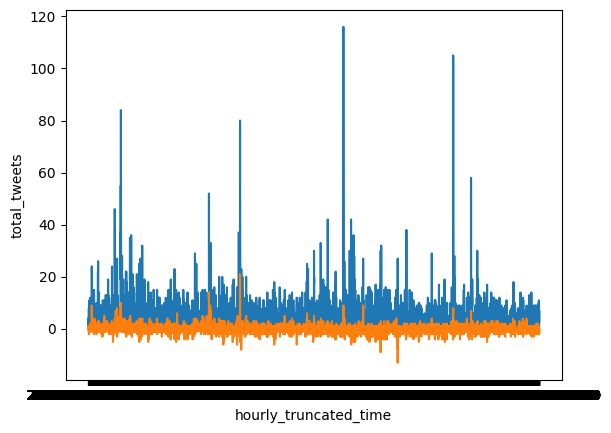

In [112]:
import seaborn as sns

sns.lineplot(metrics.total_tweets)
sns.lineplot(metrics.score_int)

